<a href="https://colab.research.google.com/github/Moeinh77/blog_posts_codes/blob/main/pfam_esm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### install the required libraries

In [ ]:
!pip install kaggle # kaggle library for downloading the data
!pip install evaluate # evaluate library for testing the model
!pip install transformers # hugging face transformers libraries

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 290 kB/s 
     |████████████████████████████████| 212 kB 12.0 MB/s 
     |████████████████████████████████| 451 kB 66.7 MB/s 
     |████████████████████████████████| 182 kB 33.9 MB/s 
     |████████████████████████████████| 132 kB 48.6 MB/s 
     |████████████████████████████████| 127 kB 20.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.5 MB/s 
     |████████████████████████████████| 7.6 MB 51.4 MB/s 


### Download the data from Kaggle

In [ ]:
import json
!mkdir ~/.kaggle # create a directory for kaggle
!touch ~/.kaggle/kaggle.json # create a json file for kaggle

api_token = {"username":"","key":""} # your kaggle api token which you can get from your kaggle account

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json # set the permission of the json file
!kaggle datasets download -d googleai/pfam-seed-random-split # download the dataset
!unzip pfam-seed-random-split.zip # unzip the dataset

100% 491M/493M [00:15<00:00, 42.1MB/s]
100% 493M/493M [00:16<00:00, 32.2MB/s]
Archive:  pfam-seed-random-split.zip
  inflating: random_split/dev/data-00000-of-00010  
  inflating: random_split/dev/data-00001-of-00010  
  inflating: random_split/dev/data-00002-of-00010  
  inflating: random_split/dev/data-00003-of-00010  
  inflating: random_split/dev/data-00004-of-00010  
  inflating: random_split/dev/data-00005-of-00010  
  inflating: random_split/dev/data-00006-of-00010  
  inflating: random_split/dev/data-00007-of-00010  
  inflating: random_split/dev/data-00008-of-00010  
  inflating: random_split/dev/data-00009-of-00010  
  inflating: random_split/random_split/dev/data-00000-of-00010  
  inflating: random_split/random_split/dev/data-00001-of-00010  
  inflating: random_split/random_split/dev/data-00002-of-00010  
  inflating: random_split/random_split/dev/data-00003-of-00010  
  inflating: random_split/random_split/dev/data-00004-of-00010  
  inflating: random_split/random_split/d

### Import the libraries

In [ ]:
import os
import torch
import evaluate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_metric
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

### Defining the data helper functions

In [ ]:
def read_data(name_sub_folder):
  '''This function is used to read the data from the random_split folder'''
  full_data = []
  for f in os.listdir(os.path.join('random_split', name_sub_folder)):
    data = pd.read_csv(os.path.join('random_split', name_sub_folder, f))
    full_data.append(data)
  return pd.concat(full_data)  

In [ ]:
def return_selected_classes(dataset, classes):
  '''This function is used to return the data from the dataset based on the selected classes'''
  return dataset.loc[dataset['family_id'].isin(classes)].reset_index()

In [ ]:
class SeqDataset(torch.utils.data.Dataset):
    '''This class is used to create a dataset for the model'''
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

### Read and process the data

In [ ]:
# read the data
dataset_train = read_data("train")
dataset_dev = read_data("dev")
dataset_test = read_data("test")

In [ ]:
class_count_dic = dataset_train['family_id'].value_counts().to_dict() # class count dictionary contains the class name and the number of samples in the class
classes = list(class_count_dic.keys())[1:11] # select the 10 classes from the dataset
classes

['LRR_1',
 'Acetyltransf_7',
 'His_kinase',
 'Bac_transf',
 'Lum_binding',
 'DNA_binding_1',
 'Chromate_transp',
 'Lipase_GDSL_2',
 'DnaJ_CXXCXGXG',
 'SRP54_N']

In [ ]:
# here we retrieve the different datasets based on the selected classes
dataset_train_small= return_from_dataset(dataset_train, classes) 
dataset_dev_small= return_from_dataset(dataset_dev, classes) 
dataset_test_small= return_from_dataset(dataset_test, classes) 

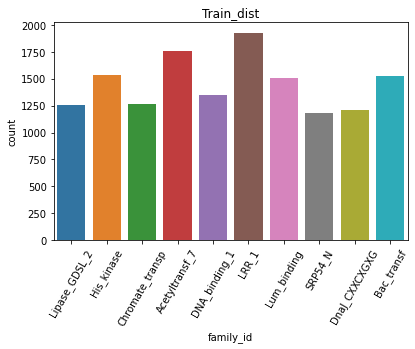

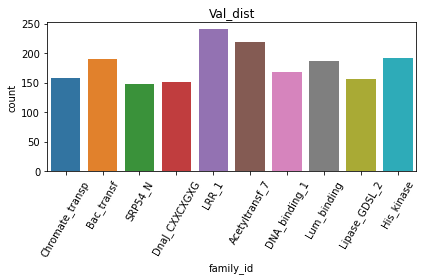

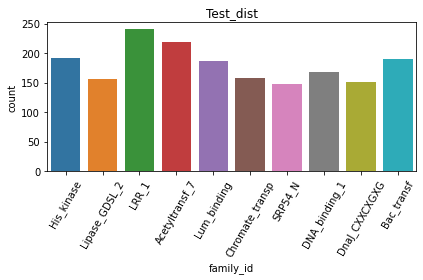

In [ ]:
# here we look at the distribution of the classes in the train, dev and test set
plt.title('Train_dist')
sns.countplot(data = dataset_train_small, x = 'family_id')
plt.tight_layout()
plt.xticks(rotation=60)
plt.show()

plt.title('Val_dist')
sns.countplot(data = dataset_dev_small, x = 'family_id')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

plt.title('Test_dist')
sns.countplot(data = dataset_test_small, x = 'family_id')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

In [ ]:
# here we calculate the length of the sequences in the train set
sequence_len_df = dataset_train_small['sequence'].apply(len)
max_len = int(np.median(np.quantile(sequence_len_df, 0.99))) # we set max_len to be the percentile 99th so we don't have to zero-pad all sequences to be length of a sequence that the longest 
max_len

217

In [ ]:
# label encoding for converting classes to integers
le = LabelEncoder()
y_train_int = le.fit_transform(dataset_train_small['family_id'])
y_dev_int = le.transform(dataset_dev_small['family_id'])
y_test_int = le.transform(dataset_test_small['family_id'])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D", do_lower_case=False, model_max_length= max_len)

train_encodings = tokenizer(dataset_train_small['sequence'].to_list(), truncation=True, padding=True, return_tensors="pt")
dev_encodings = tokenizer(dataset_dev_small['sequence'].to_list(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(dataset_test_small['sequence'].to_list(), truncation=True, padding=True, return_tensors="pt")

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--facebook--esm2_t6_8M_UR50D/snapshots/97bbd7b3dc8acb222027cde0d8e911f3de78d5b8/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--facebook--esm2_t6_8M_UR50D/snapshots/97bbd7b3dc8acb222027cde0d8e911f3de78d5b8/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--facebook--esm2_t6_8M_UR50D/snapshots/97bbd7b3dc8acb222027cde0d8e911f3de78d5b8/tokenizer_config.json


In [ ]:
train_encodings['input_ids'].shape

torch.Size([14514, 217])

In [ ]:
train_dataset = SeqDataset(train_encodings, y_train_int)
dev_dataset = SeqDataset(dev_encodings, y_dev_int)
test_dataset = SeqDataset(test_encodings, y_test_int)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("facebook/esm2_t6_8M_UR50D", num_labels= len(classes))

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--esm2_t6_8M_UR50D/snapshots/97bbd7b3dc8acb222027cde0d8e911f3de78d5b8/config.json
Model config EsmConfig {
  "_name_or_path": "facebook/esm2_t6_8M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 320,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1280,
  "is_folding_model": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL

In [ ]:
def compute_acc(eval_pred):
    '''This function is used to compute the accuracy of the model'''
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
eps = 1
bs = 16
steps = len(train_dataset) // bs 
metric = evaluate.load('accuracy')

In [ ]:
training_args = TrainingArguments(
    output_dir='./results/training_results',            # output directory
    num_train_epochs= eps,                              # total number of training epochs
    per_device_train_batch_size= bs,                    # batch size per device during training
    per_device_eval_batch_size= bs,                     # batch size for evaluation
    warmup_steps= 500,                                  # number of warmup steps for learning rate scheduler
    weight_decay= 0.01,                                 # strength of weight decay
    logging_dir= './results/training_logs',             # directory for storing logs
    logging_steps= steps,                               
    load_best_model_at_end= True,                       # load the best model at the end of training
    evaluation_strategy= 'epoch',    
    save_strategy = 'epoch'
)

trainer = Trainer(
    model=model,                                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                                 # training arguments, defined above
    train_dataset=train_dataset,                        # training dataset
    eval_dataset=dev_dataset,                           # evaluation dataset
    compute_metrics = compute_acc,                      
    tokenizer=tokenizer
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# train function starts the training
trainer.train()

***** Running training *****
  Num examples = 14514
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 908
  Number of trainable parameters = 7843210
<ipython-input-8-8c65bbd11e6c>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy
1,0.682100,0.040137,1.000000


***** Running Evaluation *****
  Num examples = 1808
  Batch size = 16
Saving model checkpoint to ./results/training_results/checkpoint-908
Configuration saved in ./results/training_results/checkpoint-908/config.json
Model weights saved in ./results/training_results/checkpoint-908/pytorch_model.bin
tokenizer config file saved in ./results/training_results/checkpoint-908/tokenizer_config.json
Special tokens file saved in ./results/training_results/checkpoint-908/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/training_results/checkpoint-908 (score: 0.04013736546039581).


TrainOutput(global_step=908, training_loss=0.6814262919899257, metrics={'train_runtime': 117.0279, 'train_samples_per_second': 124.022, 'train_steps_per_second': 7.759, 'total_flos': 141811034997240.0, 'train_loss': 0.6814262919899257, 'epoch': 1.0})

In [ ]:
# evaluate function evaluates the model on the input dataset
trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples = 1808
  Batch size = 16
<ipython-input-8-8c65bbd11e6c>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.041542381048202515,
 'eval_accuracy': 0.9994469026548672,
 'eval_runtime': 4.6924,
 'eval_samples_per_second': 385.305,
 'eval_steps_per_second': 24.082,
 'epoch': 1.0}